<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/BTC_15min_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.7 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=4a9edca857e9600d3968cd3a8e2dfbc0baeda5fd91d3f06065b08b039c7e7b43
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [30]:
import yfinance as yf
fifth_m_data = yf.download(tickers='BTC-USD', period = '60d', interval = '15m')
fifth_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-26 00:00:00+01:00,48905.289062,48981.753906,48868.722656,48981.753906,48981.753906,77778944
2021-08-26 00:15:00+01:00,48977.867188,49079.562500,48958.996094,49070.750000,49070.750000,121110528
2021-08-26 00:30:00+01:00,49031.640625,49058.988281,49004.328125,49007.035156,49007.035156,120645632
2021-08-26 00:45:00+01:00,49012.230469,49012.230469,48944.398438,48961.769531,48961.769531,2803712
2021-08-26 01:00:00+01:00,49002.640625,49081.773438,48854.484375,48963.496094,48963.496094,163721216
...,...,...,...,...,...,...
2021-10-24 17:45:00+01:00,60208.234375,60398.238281,60204.007812,60335.687500,60335.687500,34371584
2021-10-24 18:00:00+01:00,60385.980469,60483.730469,60290.398438,60340.941406,60340.941406,0
2021-10-24 18:15:00+01:00,60346.503906,60467.675781,60346.503906,60419.382812,60419.382812,58810368


In [ ]:
import datetime
#Getting the Data
start = datetime.datetime(2011, 11, 19)
end = datetime.datetime(2021, 11, 19)
df = pdr.get_data_yahoo("BTC-USD", start=start, end=end)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2021-10-20,64284.585938,66930.390625,63610.675781,65992.835938,65992.835938,40788955582
2021-10-21,66002.234375,66600.546875,62117.410156,62210.171875,62210.171875,45908121370
2021-10-22,62237.890625,63715.023438,60122.796875,60692.265625,60692.265625,38434082775


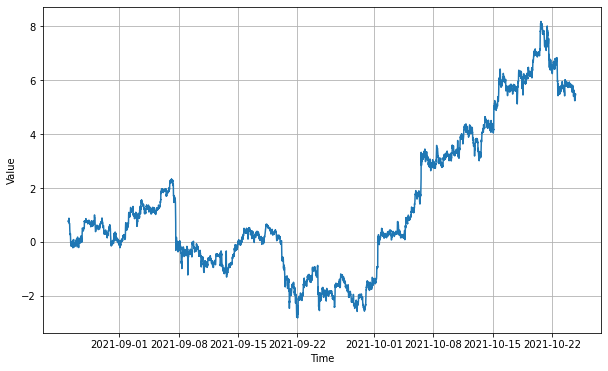

In [31]:
from sklearn.preprocessing import StandardScaler

series = fifth_m_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(fifth_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [32]:
split_time = 5000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [34]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(5000,)
Epoch 1/100
20/20 [==============================] - 5s 53ms/step - loss: 3.4459 - mae: 3.8975
Epoch 2/100
20/20 [==============================] - 1s 62ms/step - loss: 3.2938 - mae: 3.7464
Epoch 3/100
20/20 [==============================] - 1s 57ms/step - loss: 3.1241 - mae: 3.5781
Epoch 4/100
20/20 [==============================] - 1s 59ms/step - loss: 2.9550 - mae: 3.4124
Epoch 5/100
20/20 [==============================] - 1s 59ms/step - loss: 2.7937 - mae: 3.2541
Epoch 6/100
20/20 [==============================] - 1s 59ms/step - loss: 2.6411 - mae: 3.1021
Epoch 7/100
20/20 [==============================] - 1s 60ms/step - loss: 2.5009 - mae: 2.9626
Epoch 8/100
20/20 [==============================] - 1s 59ms/step - loss: 2.3732 - mae: 2.8339
Epoch 9/100
20/20 [==============================] - 1s 57ms/step - loss: 2.2556 - mae: 2.7146
Epoch 10/100
20/20 [=======================

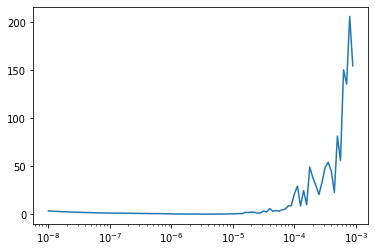

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [37]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
50/50 [==============================] - 6s 35ms/step - loss: 1.0967 - mae: 1.5156
Epoch 2/150
50/50 [==============================] - 2s 37ms/step - loss: 0.4646 - mae: 0.8313
Epoch 3/150
50/50 [==============================] - 2s 36ms/step - loss: 0.2053 - mae: 0.4764
Epoch 4/150
50/50 [==============================] - 2s 35ms/step - loss: 0.1198 - mae: 0.3350
Epoch 5/150
50/50 [==============================] - 2s 38ms/step - loss: 0.0875 - mae: 0.2805
Epoch 6/150
50/50 [==============================] - 2s 35ms/step - loss: 0.0923 - mae: 0.3019
Epoch 7/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0979 - mae: 0.3175
Epoch 8/150
50/50 [==============================] - 2s 35ms/step - loss: 0.0787 - mae: 0.2810
Epoch 9/150
50/50 [==============================] - 2s 36ms/step - loss: 0.0676 - mae: 0.2651
Epoch 10/150
50/50 [==============================] - 2s 38ms/step - loss: 0.1153 - mae: 0.3642
Epoch 11/150
50/50 [=============================

In [38]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

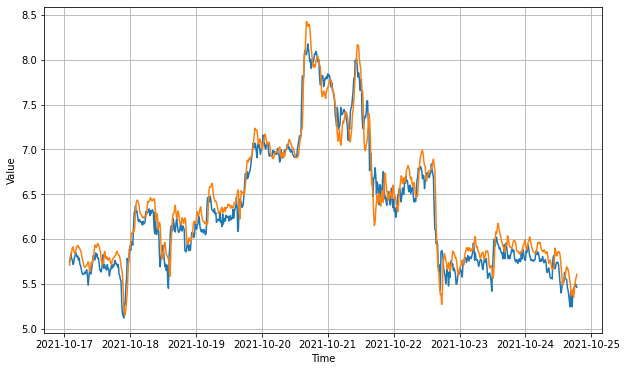

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.3300717

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[14.350295 14.352152 14.384193 ... 31.310406 31.240156 31.179567]
